# Issues to Change Requests Metric

### Connect to the Database

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import json
warnings.filterwarnings('ignore')

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

print("Done")

Done


### Retrieve Repositories in the Database

In [2]:
repolist = pd.DataFrame()

repo_query = salc.sql.text(f"""
             SELECT a.rg_name,
                a.repo_group_id,
                b.repo_name,
                b.repo_id,
                b.forked_from,
                b.repo_archived 
            FROM
                repo_groups a,
                repo b 
            WHERE
                a.repo_group_id = b.repo_group_id 
            ORDER BY
                rg_name,
                repo_name;   

    """)

repolist = pd.read_sql(repo_query, con=engine)

display(repolist)

repolist.dtypes

,rg_name,repo_group_id,repo_name,repo_id,forked_from,repo_archived
0,chaoss,25155,augur,25440,Parent not available,0.0
1,chaoss,25155,augur-license,25460,Parent not available,0.0
2,chaoss,25155,governance,25449,Parent not available,0.0
3,chaoss,25155,grimoirelab,25448,Parent not available,0.0
4,chaoss,25155,grimoirelab-bestiary,25443,Parent not available,0.0
...,...,...,...,...,...,...
75,SaltStack,60017,salt-winrepo-ng,30356,Parent not available,0.0
76,SaltStack,60017,salty-vagrant,30362,Parent not available,0.0
77,SaltStack,60017,sublime-text,30347,Parent not available,0.0
78,SaltStack,60017,takara,30380,Parent not available,1.0


rg_name           object
repo_group_id      int64
repo_name         object
repo_id            int64
forked_from       object
repo_archived    float64
dtype: object

### Repository Filters

In [3]:
# All repo ids to produce charts for.
repo_set = repolist['repo_id']

# DELETE THE FOLLOWING LINE TO PERFORM THIS ON ALL REPOSITORIES - TAKES A WHILE!
repo_set = repo_set[0:5] # Preserves only some repositories, because having the full list done for the following code would be too large

# graph_dispay can be set as 'repository' or 'competitors'.
# 'repository' will produce a graph of the issues to change requests statistic over time.
# 'competitors' will compare a repository versus other competiting repositories, so it is easy to see where the repository stands.
graph_display = 'repository'

# If graph_display is set to 'competitors', then enter the repository IDs you do no want to alias (compare).
# If graph_display is set to 'repository', then this list will not effect anything.
not_aliased_repos = [25440, 25448]

# group_by can be set as 'month' or 'year'. This determines the span of time for graphs when graph_display is set to 'repository'.
group_by = 'month'

# Specify the dates for filtering.
# If the 'end_date' is in the future, then the 'end_date' will default to the current date.
start_date = '2021-01-01'
end_date = '2021-12-31'

if end_date > pd.to_datetime('today').strftime("%Y-%m-%d"):
    end_date = pd.to_datetime('today').strftime("%Y-%m-%d")

print("Repositories:")
for repo in repo_set:
    print("\t{}".format(repo))

Repositories:
	25440
	25460
	25449


### Query Issues and Change Requests Data

In [4]:
issues_df = pd.DataFrame() # df stands for 'Data Frame'
pullrequests_df = pd.DataFrame()
ratios_df = pd.DataFrame()

for repo_id in repo_set:
    issues_query = salc.sql.text(f"""
    SELECT DISTINCT repo_id, COUNT(issue_id) AS issues_count
    FROM augur_data.issues
    WHERE repo_id = {repo_id}
    GROUP BY repo_id
""")
    df_first_repo = pd.read_sql(issues_query, con=engine)
    if not issues_df.empty:
        issues_df = pd.concat([issues_df, df_first_repo]) 
    else:
        issues_df = df_first_repo # first repo
    
    pullrequests_query = salc.sql.text(f"""
    SELECT DISTINCT repo_id, COUNT(pull_request_id) AS pr_count
    FROM augur_data.pull_requests
    WHERE repo_id = {repo_id}
    GROUP BY repo_id
""")
    prdf_first_repo = pd.read_sql(pullrequests_query, con=engine)
    if not pullrequests_df.empty:
        pullrequests_df = pd.concat([pullrequests_df, prdf_first_repo])
    else:
        pullrequests_df = prdf_first_repo

# Combine the count of issues and pull requests per repository ID.
ratios_df = pd.merge(left=issues_df, right=pullrequests_df, how='outer', on='repo_id')

# Set the proper indices for each DataFrame
issues_df.index = [x for x in range(0, len(issues_df.values))]
pullrequests_df.index = [x for x in range(0, len(issues_df.values))]
ratios_df.index = [x for x in range(0, len(ratios_df.values))]

# Define and set a new column ratio to hold the ratio for each repository.
for repo in repo_set:
    ratios_df['ratio'] = ratios_df['issues_count']/ratios_df['pr_count']

# Sort the values in the DataFrame
ratios_df = ratios_df.sort_values(by='repo_id')

months_df = pd.DataFrame() # Months Data Frame

months_query = salc.sql.text(f"""
    SELECT * FROM (
        SELECT
            date_part( 'year', created_month :: DATE ) AS year,
            date_part( 'month', created_month :: DATE ) AS MONTH
        FROM (
            SELECT * FROM ( 
                SELECT created_month :: DATE FROM generate_series (TIMESTAMP '{start_date}', TIMESTAMP '{end_date}', INTERVAL '1 month' ) created_month ) d ) x 
        ) y
""")
months_df = pd.read_sql(months_query, con=engine)

print("Ratios Data Frame")
display(ratios_df)
print("Months Data Frame")
display(months_df)


Ratios Data Frame


,repo_id,issues_count,pr_count,ratio
0,25440,1028,889,1.156355
2,25449,236,244,0.967213
1,25460,14,13,1.076923


Months Data Frame


,year,month
0,2021.0,1.0
1,2021.0,2.0
2,2021.0,3.0
3,2021.0,4.0
4,2021.0,5.0


### Calculate the Ratio of Issues to Change Requests per Repository

In [5]:
# Print the ratio for each repository
ratios = ratios_df['ratio']
for i in range(0, len(ratios_df.values)):
    issues = ratios_df.loc[i, 'issues_count']
    prs = ratios_df.loc[i, 'pr_count']
    print("Repository ID: {}".format(ratios_df.loc[i, 'repo_id']))
    print("\tIssues: {0}\tPull Requests: {1}".format(issues, prs))
    print("\tRatio of Issues to Pull Requests: {0}/{1} = {2}".format(issues, prs, ratios_df.loc[i, 'ratio']))

# TO DO FROM HERE: CREATE VISUALIZATION

Repository ID: 25440
	Issues: 1028	Pull Requests: 889
	Ratio of Issues to Pull Requests: 1028/889 = 1.156355455568054
Repository ID: 25460
	Issues: 14	Pull Requests: 13
	Ratio of Issues to Pull Requests: 14/13 = 1.0769230769230769
Repository ID: 25449
	Issues: 236	Pull Requests: 244
	Ratio of Issues to Pull Requests: 236/244 = 0.9672131147540983


### Define the Vertical Bar Chart Generator

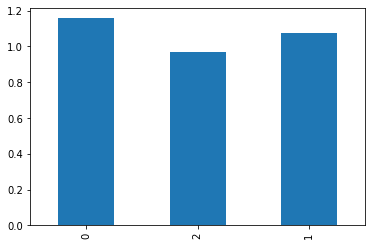

In [6]:
#import visualization libraries
from bokeh.io import output_notebook, show, export_png
from bokeh.plotting import figure
from bokeh.models import Label, LabelSet, ColumnDataSource, Legend
from bokeh.palettes import Colorblind
from bokeh.layouts import gridplot
from bokeh.transform import cumsum

from math import pi

#p = figure(x_range=data['dates'], plot_height=400, plot_width = plot_width, title=title.format(repo_dict[repo_id], 
#    contributor_type.capitalize(), number, group_by_format_string), y_range=(0, max(data['new_contributor_counts'])* 1.15), 
#    margin = (0, 0, 10, 0))
#plot = figure(x_range=(0, len(ratios_df.values)), 
#        y_range=(0, max(max(ratios_df['issues_count'].values), max(ratios_df['pr_count'].values))*1.15), 
#        plot_height=400, plot_width=100*len(ratios_df.values), title="This is a test title", margin=(0, 0, 10, 0))
#plot.vbar(x=ratios_df['issues_count'], width=0.8)
#caption_plot = figure(plot_width = 100*len(ratios_df.values), plot_height=200, margin=(0, 0, 0, 0))
#caption_plot.add_layout(Label(
#                x = 0, # Change to shift caption left or right
#                y = 160, 
#                x_units = 'screen',
#                y_units = 'screen',
#                text='Sample Text is being put here for now',
#                text_font = 'times', # Use same font as paper
#                text_font_size = '15pt',
#                render_mode='css'
#                ))
#grid = gridplot([[plot, caption_plot]])
#show(grid)

# Plots the issues and pull requests for each repository
#ratios_df.drop('repo_id', axis=1).plot.bar()

# Plots the ratio for each repository
ratios_df['ratio'].plot.bar()

#def vertical_bar_chart(input_df, repo_id, 

### Pre-made Sample Graphs

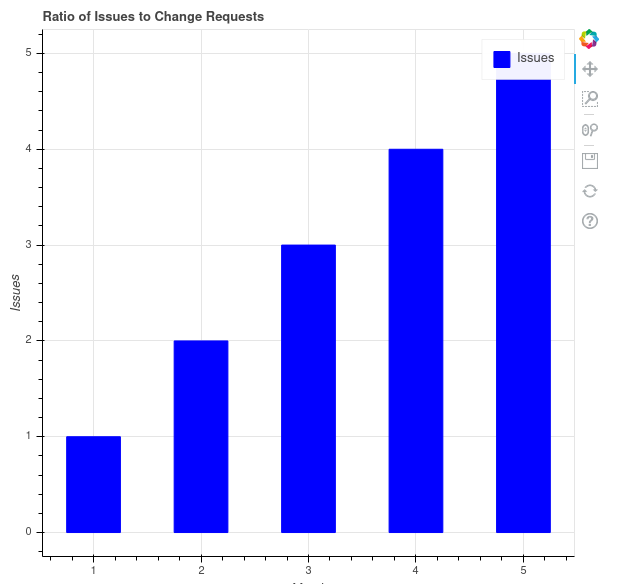

In [7]:
from IPython import display
display.Image("images/graph1.png")

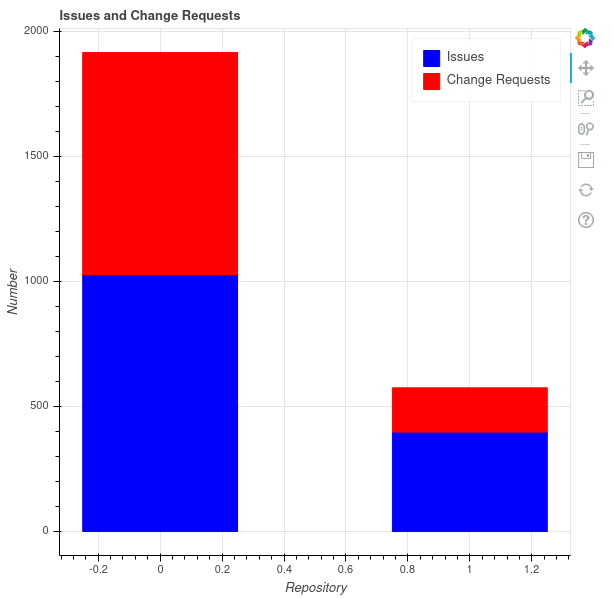

In [8]:
display.Image("images/graph2.png")